In [1]:
# https://www.kaggle.com/pankajj/fashion-mnist-with-pytorch-93-accuracy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [2]:
from res.plot_lib import plot_data, plot_model, set_default

In [3]:
set_default()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)       

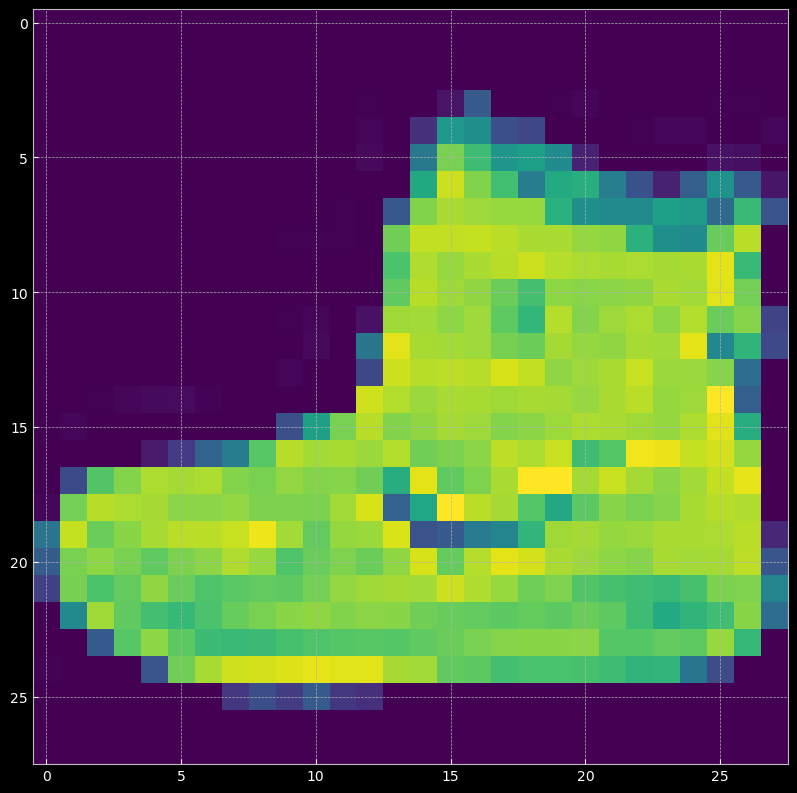

In [7]:
a = next(iter(train_loader))
plt.imshow(a[0][0][0])

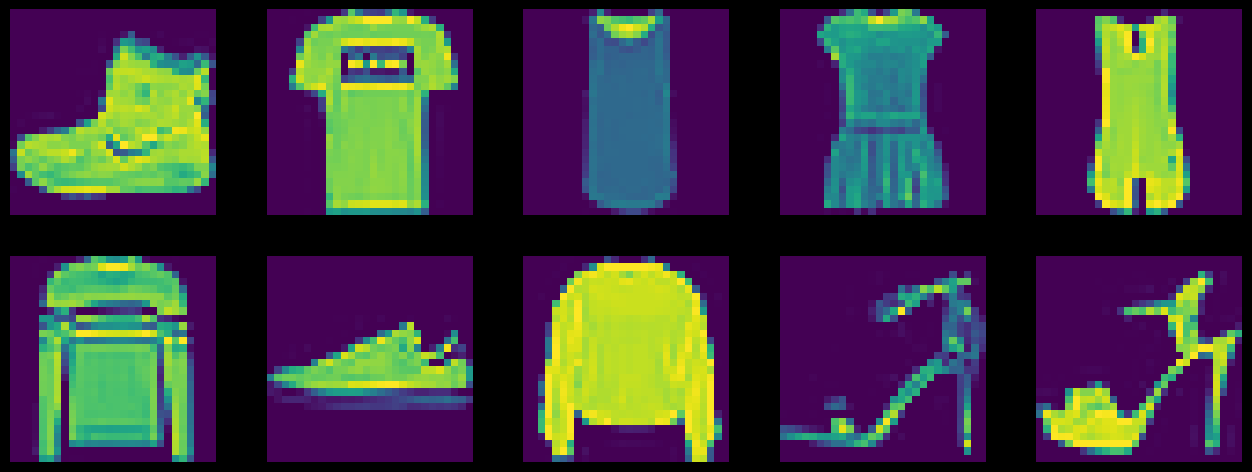

In [8]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

In [9]:
# Making a method that return the name of class for the label number. ex. if the label is 5, we return Sandal.
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

Buliding CNN

In [10]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=50, kernel_size=3, padding=1)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=50, out_channels=100, kernel_size=3)
       )
        
        
        self.fc1 = nn.Linear(in_features=100*6*6, out_features=800)
        self.fc2 = nn.Linear(in_features=800, out_features=400)
        self.fc3 = nn.Linear(in_features=400, out_features=120)
        self.fc4 = nn.Linear(in_features= 120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = F.relu(out)
        out = F.max_pool2d(out,kernel_size=2)
        out = self.layer2(out)
        out = F.relu(out)
        out = F.max_pool2d(out,kernel_size=2)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.log_softmax(out,dim=1)
        
        return out
    
    def get_images1(self, x):
        out = self.layer1(x)
        out = F.relu(out)
        out = F.max_pool2d(out,kernel_size=2)
        
        return out
    
    def get_images2(self,x):
        out = self.layer1(x)
        out = F.relu(out)
        out = F.max_pool2d(out,kernel_size=2)
        out = self.layer2(out)
        out = F.relu(out)
        out = F.max_pool2d(out,kernel_size=2)
        
        return out

In [11]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layer2): Sequential(
    (0): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1))
  )
  (fc1): Linear(in_features=3600, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=120, bias=True)
  (fc4): Linear(in_features=120, out_features=10, bias=True)
)


In [12]:
num_epochs = 10
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.591586709022522, Accuracy: 79.29000091552734%
Iteration: 1000, Loss: 0.4455925226211548, Accuracy: 84.43000030517578%
Iteration: 1500, Loss: 0.4028603434562683, Accuracy: 84.31999969482422%
Iteration: 2000, Loss: 0.30418166518211365, Accuracy: 87.27999877929688%
Iteration: 2500, Loss: 0.2967257797718048, Accuracy: 88.07999420166016%
Iteration: 3000, Loss: 0.22388586401939392, Accuracy: 88.4000015258789%
Iteration: 3500, Loss: 0.359871506690979, Accuracy: 89.08999633789062%
Iteration: 4000, Loss: 0.2973823845386505, Accuracy: 89.31999969482422%
Iteration: 4500, Loss: 0.282509446144104, Accuracy: 88.58999633789062%
Iteration: 5000, Loss: 0.2356511950492859, Accuracy: 89.6199951171875%
Iteration: 5500, Loss: 0.21107777953147888, Accuracy: 90.02999877929688%
Iteration: 6000, Loss: 0.18735887110233307, Accuracy: 89.81999969482422%


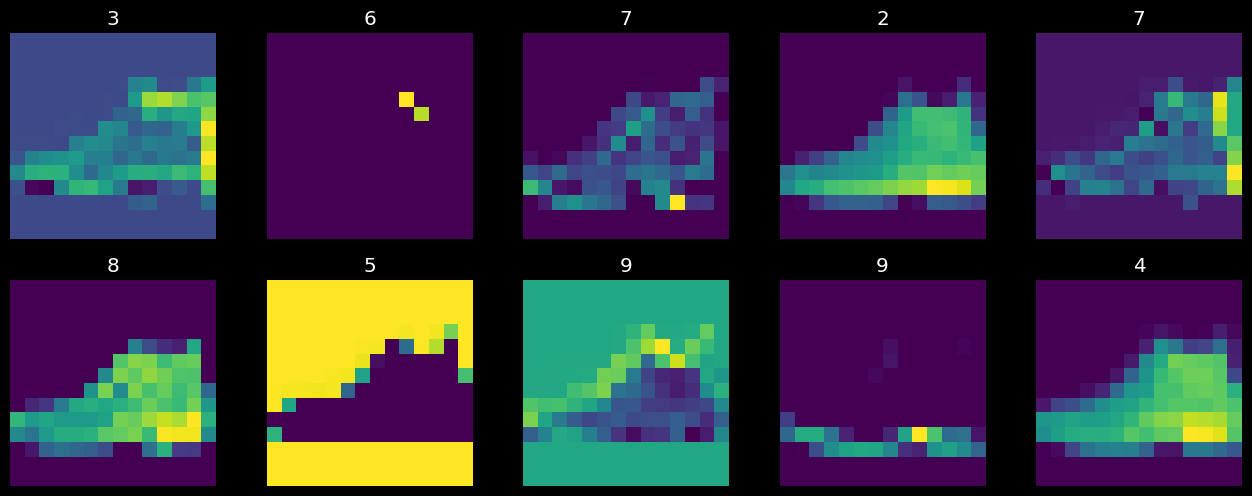

In [13]:
i = 0
for images,labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    i += 1
    if i > 1:
        break
    outputs = model.get_images1(images)
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
#     image = outputs.__getitem__(i)
    plt.imshow(outputs[0].cpu().data.numpy()[i])
    plt.title(labels.cpu()[i].numpy())
    plt.axis('off');
#                  0: "T-shirt/Top",
#                  1: "Trouser",
#                  2: "Pullover",
#                  3: "Dress",
#                  4: "Coat", 
#                  5: "Sandal", 
#                  6: "Shirt",
#                  7: "Sneaker",
#                  8: "Bag",
#                  9: "Ankle Boot"

In [14]:
# outputs[0].cpu().data.numpy()

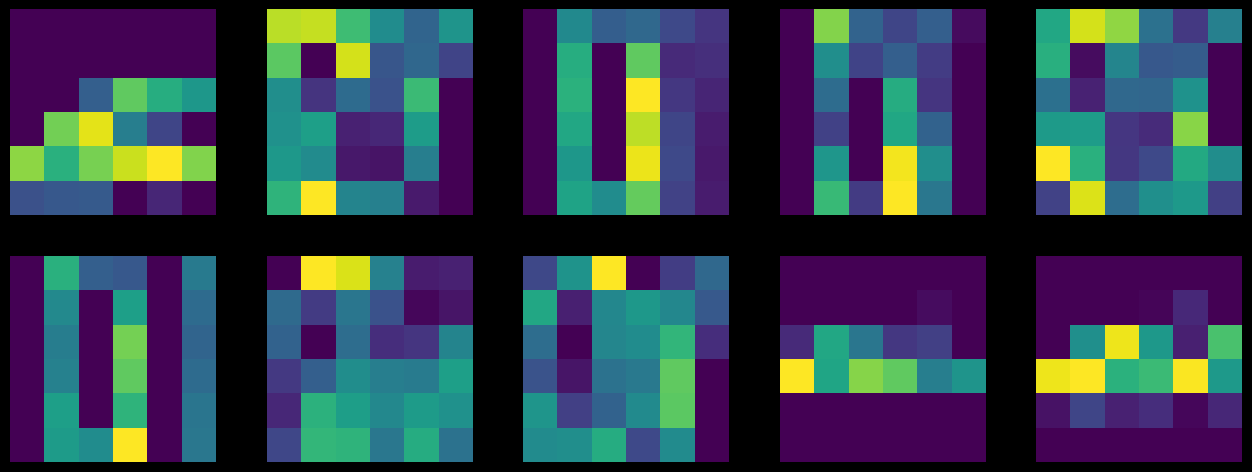

In [15]:
i = 0
for images,labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    i += 1
    if i > 1:
        break
    outputs = model.get_images2(images)
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = outputs.__getitem__(i)
    plt.imshow(image[0].cpu().data.numpy())
    plt.axis('off');

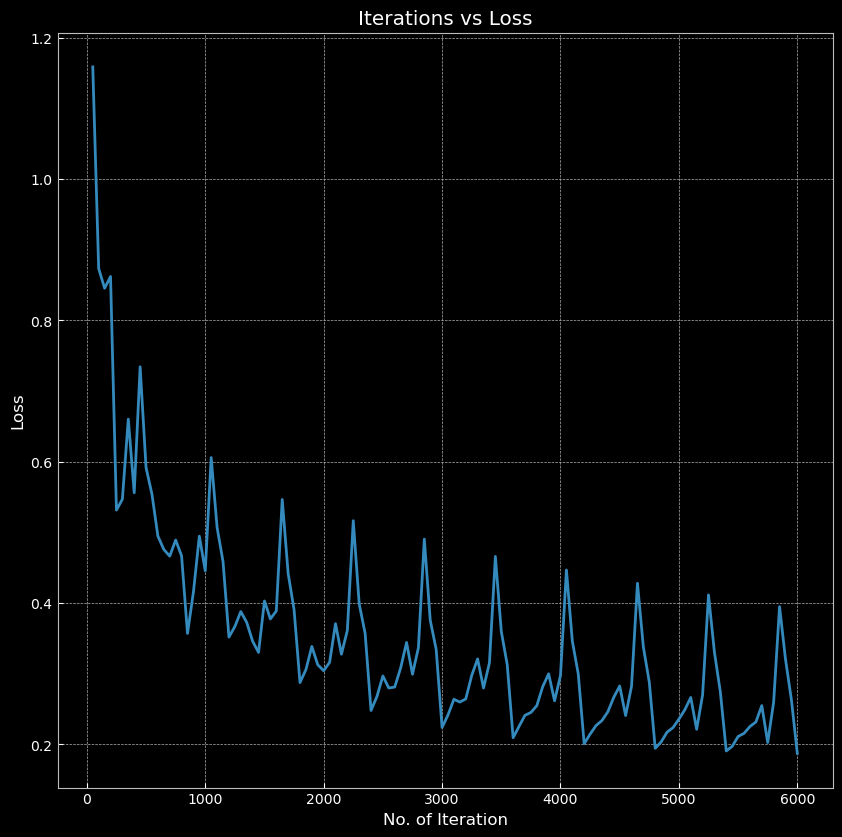

In [16]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

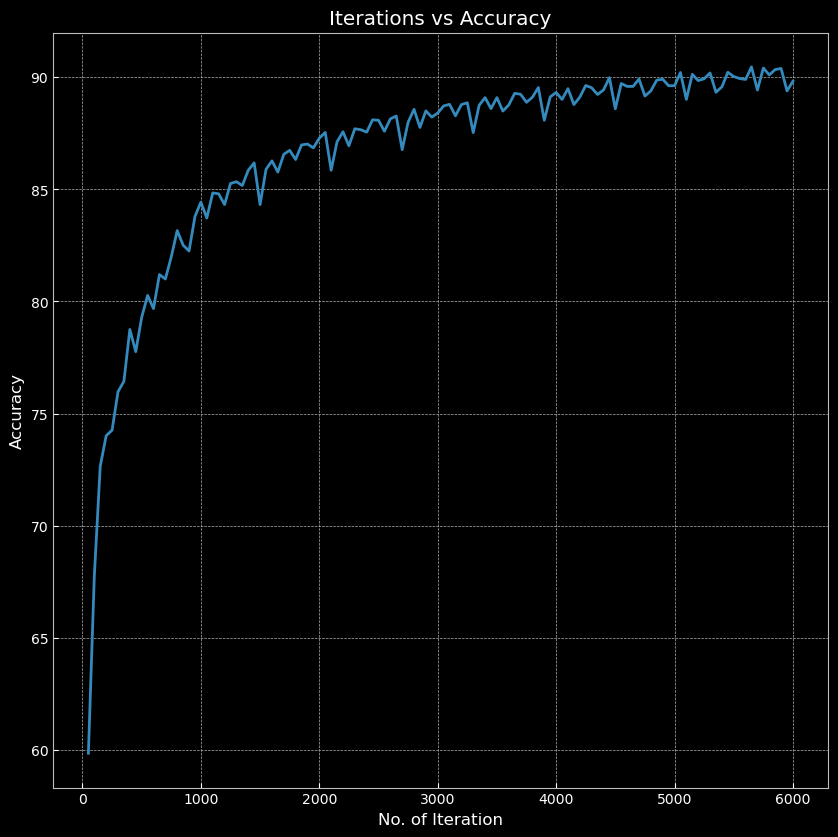

In [17]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()


In [18]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 90.20%
Accuracy of Trouser: 97.00%
Accuracy of Pullover: 77.30%
Accuracy of Dress: 88.90%
Accuracy of Coat: 84.00%
Accuracy of Sandal: 96.40%
Accuracy of Shirt: 72.70%
Accuracy of Sneaker: 96.90%
Accuracy of Bag: 98.20%
Accuracy of Ankle Boot: 96.60%
